In [2]:
# Basic python utilities
import numpy as np
import scipy as scp 
from scipy.stats import gamma
from scipy.stats import mode
from scipy.stats import itemfreq
from scipy.stats import mode

import pandas as pd

# Parallelization
import multiprocessing as mp
from  multiprocessing import Process
from  multiprocessing import Pool
import psutil

# System utilities
from datetime import datetime
import time
import os
import pickle 
import uuid

# My own code
import kde_class as kde
import kde_training_utilities as kde_utils
import ddm_data_simulation as ddm_simulator 
import boundary_functions as bf

# Plotting
import matplotlib.pyplot as plt

In [2]:
# Get the folder where base simulations live
folder_ = '/home/afengler/git_repos/nn_likelihoods/data_storage/kde/linear_collapse/base_simulations/'
files_ = os.listdir(folder_)
n_files = len(files_)
init_file = pickle.load(open( folder_ + files_[0], 'rb' ))
init_cols = list(init_file[2].keys())

In [4]:
# If 'sim_stat_data' file exists and its 'file' columns has all files in the folder, we skip creation
sim_stat_data = pickle.load(open(os.getcwd() + '/data_storage/kde/weibull/simulator_statistics.pickle', 'rb'))

In [5]:
np.sum(sim_stat_data['keep_file'])

214598

In [8]:
sim_stat_data = kde_utils.filter_simulations(base_simulation_folder = folder_, param_ranges = {'a': [0.5, 2],
               'w': [0.3, 0.7],
               'v': [-1, 1],
               'theta': [0, np.pi/2.2],
               'node': [0, 5]})

1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
55000
56000
57000
58000
59000
60000
61000
62000
63000
64000
65000
66000
67000
68000
69000
70000
71000
72000
73000
74000
75000
76000
77000
78000
79000
80000
81000
82000
83000
84000
85000
86000
87000
88000
89000
90000
91000
92000
93000
94000
95000
96000
97000
98000
99000
100000
101000
102000
103000
104000
105000
106000
107000
108000
109000
110000
111000
112000
113000
114000
115000
116000
117000
118000
119000
120000
121000
122000
123000
124000
125000
126000
127000
128000
129000
130000
131000
132000
133000
134000
135000
136000
137000
138000
139000
140000
141000
142000
143000
144000
145000
146000


In [ ]:
# Initialize data frame
sim_stat_data = pd.DataFrame(np.zeros((n_files, len(init_cols))), columns = init_cols)

In [ ]:
# MAX RT BY SIMULATION: TEST SHOULD BE CONSISTENT
n_simulations = init_file[2]['n_samples']
n_choices = len(init_file[2]['possible_choices'])

max_rts = []
max_ts = []

stds = np.zeros((n_files, n_choices))
mean_rts = np.zeros((n_files, n_choices))
choice_cnts = np.zeros((n_files, n_choices))
modes = np.zeros((n_files, n_choices))
mode_cnts = np.zeros((n_files, n_choices))

sim_stat_data = [None] * n_files

cnt = 0
for file_ in files_:
    tmp = pickle.load(open( folder_ + file_ , 'rb'))
    max_rts.append(tmp[0].max().round(2))
    max_ts.append(tmp[2]['max_t'])
    
    # Standard deviation of reaction times
    choice_cnt = 0
    for choice_tmp in tmp[2]['possible_choices']:
        
        tmp_rts = tmp[0][tmp[1] == choice_tmp]
        n_c = len(tmp_rts)
        choice_cnts[cnt, choice_cnt] = n_c
        
        mode_tmp = mode(tmp_rts)

        if n_c > 0:
            mean_rts[cnt, choice_cnt] = np.mean(tmp_rts)
            stds[cnt, choice_cnt] = np.std(tmp_rts)
            modes[cnt, choice_cnt] = float(mode_tmp[0])
            mode_cnts[cnt, choice_cnt] = int(mode_tmp[1])
        else:
            mean_rts[cnt, choice_cnt] = -1
            stds[cnt, choice_cnt] = -1
            modes[cnt, choice_cnt] = -1
            mode_cnts[cnt, choice_cnt] = 0
        
        choice_cnt += 1
    
    # Basic data column
    sim_stat_data[cnt] = [tmp[2][key] for key in list(tmp[2].keys())]
    
    cnt += 1
    if cnt % 1000 == 0:
        print(cnt)

sim_stat_data = pd.DataFrame(sim_stat_data, columns = init_file[2].keys())

for i in range(0, n_choices, 1):
    # Columns directly from stats collected in previous loop
    sim_stat_data['mean_rt_' + str(i)] = mean_rts[:, i]
    sim_stat_data['std_' + str(i)] = stds[:, i]
    sim_stat_data['choice_cnt_' + str(i)] = choice_cnts[:,i]
    sim_stat_data['mode_' + str(i)] = modes[:, i]
    sim_stat_data['mode_cnt_' + str(i)] = mode_cnts[:, i]
    
    # Derived Columns
    sim_stat_data['choice_prop_' + str(i)] = sim_stat_data['choice_cnt_' + str(i)] / n_simulations
    sim_stat_data['mode_cnt_rel_' + str(i)] = sim_stat_data['mode_cnt_' + str(i)] / sim_stat_data['choice_cnt_' + str(i)]
    
sim_stat_data['file'] = files_
        
# check that max_t is consistently the same value across simulations
assert len(np.unique(max_ts)) == 1

# check that max_rt is <= max_t + 0.00001 (adding for rounding)
assert max(max_rts) <= np.unique(max_ts)[0] + 0.0001

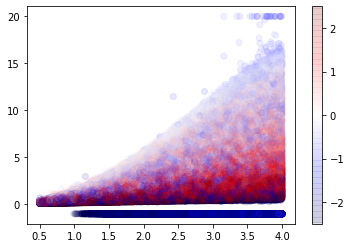

In [6]:
# SOME GRAPHS TO ILLUSTRATE BEHAVIOR OF SIMULATOR
grayscale_map = plt.get_cmap('seismic')
plt.figure()

plt.scatter(sim_stat_data['a'], sim_stat_data['mean_rt_1'],
            c = sim_stat_data['v'], 
            cmap = grayscale_map, 
            alpha = 0.1)

plt.colorbar()
plt.show()

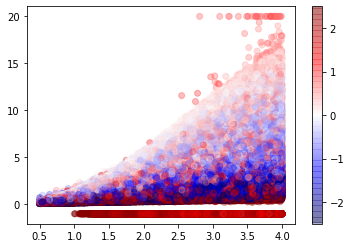

In [7]:
# SOME GRAPHS TO ILLUSTRATE BEHAVIOR OF SIMULATOR
grayscale_map = plt.get_cmap('seismic')
plt.figure()

plt.scatter(sim_stat_data['a'], sim_stat_data['mean_rt_0'],
            c = sim_stat_data['v'], 
            cmap = grayscale_map, 
            alpha = 0.1)

plt.colorbar()
plt.show()

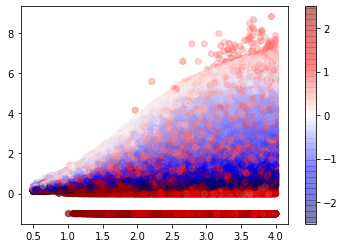

In [11]:
# VARIANCE RELATIONSHIP WITH A
# SOME GRAPHS TO ILLUSTRATE BEHAVIOR OF SIMULATOR
grayscale_map = plt.get_cmap('seismic')
plt.figure()

plt.scatter(sim_stat_data['a'], sim_stat_data['std_0'],
            c = sim_stat_data['v'], 
            cmap = grayscale_map, 
            alpha = 0.3)

plt.colorbar()
plt.show()

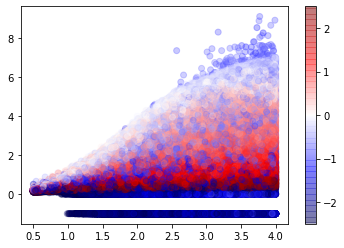

In [12]:
# VARIANCE RELATIONSHIP WITH A
# SOME GRAPHS TO ILLUSTRATE BEHAVIOR OF SIMULATOR
grayscale_map = plt.get_cmap('seismic')
plt.figure()

plt.scatter(sim_stat_data['a'], sim_stat_data['std_1'],
            c = sim_stat_data['v'], 
            cmap = grayscale_map, 
            alpha = 0.3)

plt.colorbar()
plt.show()

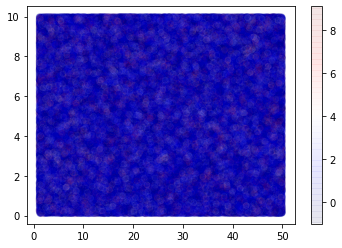

In [16]:
# VARIANCE RELATIONSHIP WITH A
# SOME GRAPHS TO ILLUSTRATE BEHAVIOR OF SIMULATOR
grayscale_map = plt.get_cmap('seismic')
plt.figure()

plt.scatter(sim_stat_data['shape'], sim_stat_data['scale'],
            c = sim_stat_data['std_1'], 
            cmap = grayscale_map, 
            alpha = 0.05)

plt.colorbar()
plt.show()

In [ ]:
from scipy.stats import itemfreq
from scipy.stats import mode

In [ ]:
sim_stat_data

In [ ]:
# Set conditions for exclusion:

# mode == 20 exclude
# choice_cnt < 10 exclude
# choice_cnt >= 10 but std = 0 
# mean_rt > 15 exclude 

np.where(sim_stat_data['mode_0'] == 20.0)

In [ ]:
sim_stat_data = sim_stat_data.round(decimals = 2)
sim_stat_data = sim_stat_data.fillna(value = 0)

In [18]:
# Apply parameter filter
param_ranges = {'a': [0.5, 2],
               'w': [0.3, 0.7],
               'v': [-1, 1],
               'shape': [1.01, 100],
               'scale': [0, 5]}
cnt = 0
for param in param_ranges.keys():
    if cnt == 0:
        keep = (sim_stat_data[param] >= param_ranges[param][0]) & (sim_stat_data[param] <= param_ranges[param][1])
    else:
        keep = (keep) & \
               (sim_stat_data[param] >= param_ranges[param][0]) & (sim_stat_data[param] <= param_ranges[param][1])
    cnt += 1

# Apply sanity checks 
keep =  (keep) & \
        (sim_stat_data['mode_0'] != 20) & (sim_stat_data['mode_1'] != 20) & \
        (sim_stat_data['choice_cnt_0'] > 10) & (sim_stat_data['choice_cnt_1'] > 10) & \
        (sim_stat_data['mean_rt_0'] < 15) & (sim_stat_data['mean_rt_1'] < 15) & \
        (sim_stat_data['std_0'] > 0) & (sim_stat_data['std_1'] > 0) & \
        (sim_stat_data['mode_cnt_rel_0'] < 0.5) & (sim_stat_data['mode_cnt_rel_1'] < 0.5)

In [19]:
np.sum(keep)

19256

In [18]:
sim_stat_data['a'].dtype

dtype('float16')

In [ ]:
# Check n remaining files
np.sum(keep)

In [ ]:
list(sim_stat_data.loc[keep, 'file'])

In [ ]:
sim_stat_data_keep = sim_stat_data.loc[keep, :]

In [ ]:
sim_stat_data_throw = sim_stat_data.loc[np.invert(keep), :]

In [ ]:
# Write to file
pickle.dump(list(sim_stat_data_keep['file']), open(folder_ + '/keep_files.pickle', 'wb'))
pickle.dump(sim_stat_data, open(folder_ + '/simulator_statistics.pickle', 'wb'))

In [ ]:
# Problem: max_rt
grayscale_map = plt.get_cmap('seismic')
plt.figure()

plt.scatter(sim_stat_data_throw.loc[sim_stat_data_throw['mode_0'] == 20,'a'], 
            sim_stat_data_throw.loc[sim_stat_data_throw['mode_0'] == 20, 'v'], 
            c = sim_stat_data_throw.loc[sim_stat_data_throw['mode_0'] == 20, 'w'],
            cmap = grayscale_map,
            alpha = 0.5)

plt.ylim((-2.5, 2.5))

plt.colorbar()
plt.show()

In [ ]:
# Problem: choice_cnt_0 < 10
grayscale_map = plt.get_cmap('seismic')
plt.figure()

plt.scatter(sim_stat_data_throw.loc[sim_stat_data_throw['choice_cnt_0'] < 10,'a'], 
            sim_stat_data_throw.loc[sim_stat_data_throw['choice_cnt_0'] < 10, 'v'],
            c = sim_stat_data_throw.loc[sim_stat_data_throw['choice_cnt_0'] < 10, 'w'],
            cmap = grayscale_map,
            alpha = 0.1)

plt.colorbar()
plt.show()

In [ ]:
# Problem: choice_cnt_1 < 10
grayscale_map = plt.get_cmap('seismic')
plt.figure()

plt.scatter(sim_stat_data_throw.loc[sim_stat_data_throw['choice_cnt_1'] < 10,'a'], 
            sim_stat_data_throw.loc[sim_stat_data_throw['choice_cnt_1'] < 10, 'v'],
            c = sim_stat_data_throw.loc[sim_stat_data_throw['choice_cnt_1'] < 10, 'w'],
            cmap = grayscale_map,
            alpha = 0.1)

plt.colorbar()
plt.show()

In [ ]:
# Problem: choice_cnt_1 < 10
grayscale_map = plt.get_cmap('seismic')
plt.figure()

plt.scatter(sim_stat_data_throw.loc[sim_stat_data_throw['choice_cnt_1'] < 10,'a'], 
            sim_stat_data_throw.loc[sim_stat_data_throw['choice_cnt_1'] < 10, 'v'],
            c = sim_stat_data_throw.loc[sim_stat_data_throw['choice_cnt_1'] < 10, 'theta'],
            cmap = grayscale_map,
            alpha = 0.05)

plt.colorbar()
plt.show()

In [ ]:
# Problem: std_0 = 0 while choices observed
grayscale_map = plt.get_cmap('seismic')
plt.figure()

plt.scatter(sim_stat_data_throw.loc[(sim_stat_data_throw['std_0'] == 0.0) & (sim_stat_data_throw['choice_cnt_0'] >= 10),'a'], 
            sim_stat_data_throw.loc[(sim_stat_data_throw['std_0'] == 0.0) & (sim_stat_data_throw['choice_cnt_0'] >= 10), 'v'],
            c = sim_stat_data_throw.loc[(sim_stat_data_throw['std_0'] == 0.0) & (sim_stat_data_throw['choice_cnt_0'] >= 10), 'theta'],
            cmap = grayscale_map,
            alpha = 0.1)

plt.colorbar()
plt.show()

In [ ]:
# Problem: std_0 = 0 and lack of choices
grayscale_map = plt.get_cmap('seismic')
plt.figure()

plt.scatter(sim_stat_data_throw.loc[(sim_stat_data_throw['std_0'] == 0.0) & (sim_stat_data_throw['choice_cnt_0'] < 2),'a'], 
            sim_stat_data_throw.loc[(sim_stat_data_throw['std_0'] == 0.0) & (sim_stat_data_throw['choice_cnt_0'] < 2), 'v'],
            c = sim_stat_data_throw.loc[(sim_stat_data_throw['std_0'] == 0.0) & (sim_stat_data_throw['choice_cnt_0'] < 2), 'theta'],
            cmap = grayscale_map,
            alpha = 0.1)

plt.colorbar()
plt.show()

In [ ]:
# Problem: mode_cnt_rel_1
grayscale_map = plt.get_cmap('seismic')
plt.figure()

plt.scatter(sim_stat_data_throw.loc[(sim_stat_data_throw['mode_cnt_rel_1'] > 0.5) & (sim_stat_data_throw['mode_1'] < 20),'a'], 
            sim_stat_data_throw.loc[(sim_stat_data_throw['mode_cnt_rel_1'] > 0.5) & (sim_stat_data_throw['mode_1'] < 20), 'v'],
            c = sim_stat_data_throw.loc[(sim_stat_data_throw['mode_cnt_rel_1'] > 0.5) & (sim_stat_data_throw['mode_1'] < 20), 'mean_rt_1'],
            cmap = grayscale_map,
            alpha = 0.1)

plt.colorbar()
plt.show()

In [ ]:
# Problem: mode_cnt_rel_0
grayscale_map = plt.get_cmap('seismic')
plt.figure()

plt.scatter(sim_stat_data_throw.loc[(sim_stat_data_throw['mode_cnt_rel_0'] > 0.5) & (sim_stat_data_throw['mode_0'] < 20),'a'], 
            sim_stat_data_throw.loc[(sim_stat_data_throw['mode_cnt_rel_0'] > 0.5) & (sim_stat_data_throw['mode_0'] < 20), 'v'],
            c = sim_stat_data_throw.loc[(sim_stat_data_throw['mode_cnt_rel_0'] > 0.5) & (sim_stat_data_throw['mode_0'] < 20), 'mean_rt_0'],
            cmap = grayscale_map,
            alpha = 0.1)

plt.colorbar()
plt.show()

In [ ]:
# PROPERTIES OF KEPT DATA
grayscale_map = plt.get_cmap('seismic')
plt.figure()

plt.scatter(sim_stat_data_keep['v'], 
            sim_stat_data_keep['w'], 
            c = sim_stat_data_keep['a'], 
            cmap = grayscale_map,
            alpha = 0.1)

plt.colorbar()
plt.show()

In [10]:
sim_stat_data['std_0']

0         0.68
1         0.68
2         0.54
3         1.62
4         0.46
5        -1.00
6         0.51
7         0.33
8         0.22
9         3.42
10        2.82
11        0.38
12        0.43
13        0.88
14        1.39
15        0.81
16       -1.00
17        4.51
18        0.75
19        1.36
20        1.46
21        0.26
22        0.59
23        0.97
24        0.41
25        1.77
26        5.06
27        1.16
28        1.31
29       -1.00
          ... 
387238   -1.00
387239    0.58
387240    0.52
387241    0.87
387242    0.65
387243    6.83
387244    3.07
387245    0.82
387246    0.18
387247    0.76
387248    3.63
387249    0.85
387250    1.16
387251    0.41
387252    0.23
387253    1.37
387254    1.89
387255    1.52
387256    1.15
387257    2.96
387258    0.64
387259    0.35
387260    0.26
387261    4.72
387262    0.60
387263    3.82
387264    0.65
387265    1.40
387266    0.63
387267    0.74
Name: std_0, Length: 387268, dtype: float64